In [55]:
import pandas as pd

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df= pd.read_csv('Customer_data.csv')

In [58]:
df.head()

,customer_id,age,income,purchase_amount,gender,region,total_purchases,preferred_product_category,customer_loyalty_score,signup_date,last_purchase_date
0,1,56.0,67700.0,1019.145669,Female,South,31.0,Toys,12.501082,2022-05-01,2022-02-27
1,2,69.0,50200.0,252.214693,Male,North,27.0,Toys,14.402036,2022-03-14,2022-07-03
2,3,46.0,84000.0,354.742321,Male,East,25.0,Clothing,89.085761,2022-07-17,2022-04-13
3,4,32.0,42700.0,716.573913,Male,West,5.0,Electronics,98.800804,2022-07-09,2021-04-21
4,5,60.0,112300.0,1528.118235,Female,West,6.0,Clothing,28.893785,2021-04-21,2021-06-02


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526 entries, 0 to 3525
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 3526 non-null   int64  
 1   age                         3520 non-null   float64
 2   income                      3520 non-null   float64
 3   purchase_amount             3520 non-null   float64
 4   gender                      3519 non-null   object 
 5   region                      3520 non-null   object 
 6   total_purchases             3520 non-null   float64
 7   preferred_product_category  3518 non-null   object 
 8   customer_loyalty_score      3521 non-null   float64
 9   signup_date                 3520 non-null   object 
 10  last_purchase_date          3520 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 303.1+ KB


In [81]:
df.shape

(3526, 3)

<Axes: >

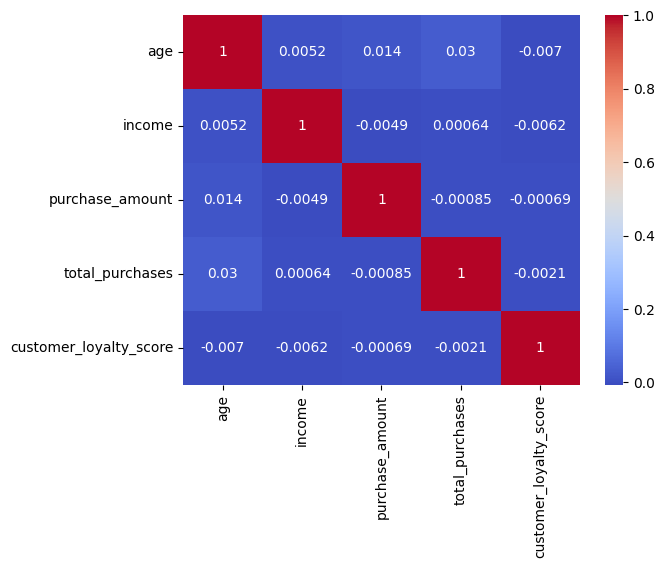

In [60]:
x=df.drop(['customer_id'], axis=1)
corr_matrix = x.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


In [61]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x['gender']= le.fit_transform(x['gender'])
x['preferred_product_category']= le.fit_transform(x['preferred_product_category']) 
x['region']= le.fit_transform(x['region'])
x=x.drop(['signup_date'], axis=1)
x=x.drop(['last_purchase_date'], axis=1)

In [62]:
x = x.fillna(x.median())


In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)


In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_pca)

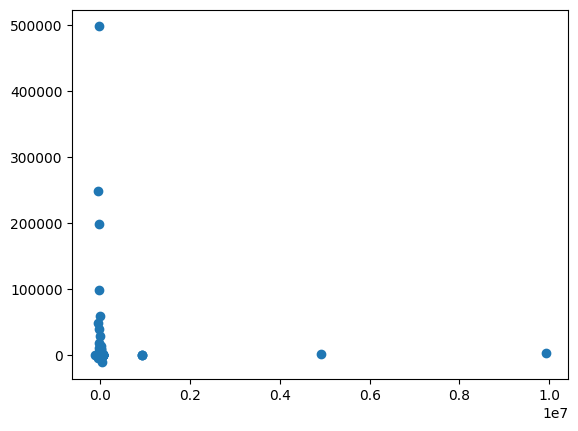

In [65]:
plt.scatter(x_pca[:,0], x_pca[:,1])

In [66]:
from sklearn.cluster import KMeans


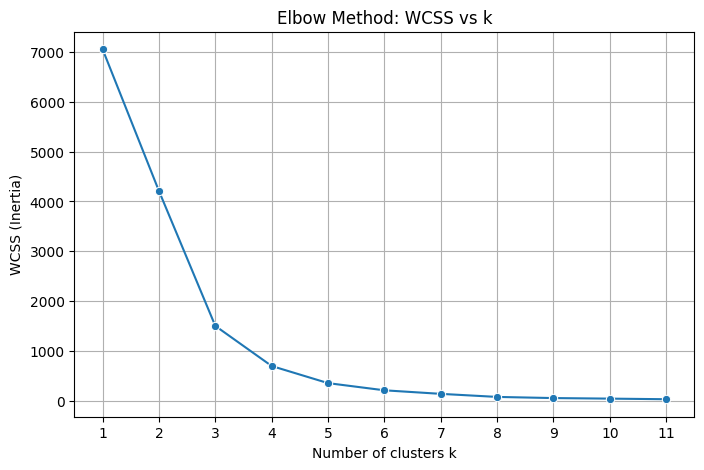

In [67]:
wcss = []
K_range = range(1, 12)  # 1..11
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(x_scaled)
    wcss.append(km.inertia_)

# Plot elbow (WCSS vs k)
plt.figure(figsize=(8,5))
sns.lineplot(x=list(K_range), y=wcss, marker='o')
plt.xticks(list(K_range))
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method: WCSS vs k')
plt.grid(True)
plt.show()

In [68]:
from kneed import KneeLocator

In [69]:
from sklearn.metrics import silhouette_score

In [70]:
k_values = list(range(2, 12))
inertias_for_k = [wcss[k-1] for k in k_values]  # wcss list indexed from k=1 at pos0

# KneeLocator expects x and y arrays. We look for the knee in the inertia curve.
knee = KneeLocator(k_values, inertias_for_k, curve='convex', direction='decreasing')
k_opt = knee.knee
print(f'Kneedle found knee at k = {k_opt}')

# If k_opt is None (kneed couldn't find it), fall back to simple heuristic: the k with largest second derivative drop
if k_opt is None:
    # compute discrete second derivative (approx) and take argmax
    diffs = np.diff(inertias_for_k)
    second_diffs = np.diff(diffs)
    idx = np.argmax(-second_diffs)  # largest concavity
    k_opt = k_values[idx+1]  # offset due to diff lengths
    print(f'Fallback heuristic selected k = {k_opt}')

# Fit KMeans with optimal k (if valid) and compute silhouette score
if k_opt is not None and k_opt >= 2:
    km_opt = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    labels_opt = km_opt.fit_predict(x_scaled)
    sil_opt = silhouette_score(x_scaled, labels_opt)
    print(f'Silhouette score for k={k_opt}: {sil_opt:.4f}')
else:
    print('No valid optimal k found by kneed or fallback; skipping silhouette for optimal k')

Kneedle found knee at k = 4
Silhouette score for k=4: 0.9887


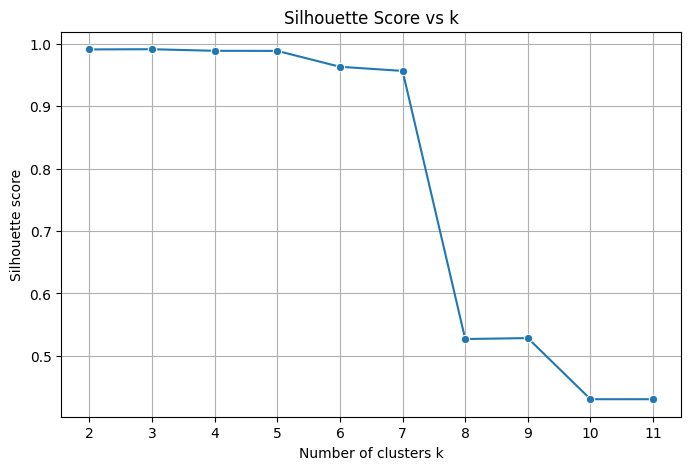

k -> silhouette score
2 -> 0.9909257856645877
3 -> 0.9912584362064599
4 -> 0.9887156991406577
5 -> 0.9885658958345226
6 -> 0.9631374178222957
7 -> 0.956500561759388
8 -> 0.5270424361381618
9 -> 0.5285490909002475
10 -> 0.4306215989453638
11 -> 0.4306070681772005


In [71]:
sil_scores = {}
for k in range(2, 12):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(x_scaled)
    try:
        s = silhouette_score(x_scaled, labels)
    except Exception as e:
        s = np.nan
    sil_scores[k] = s

# Plot silhouette scores
plt.figure(figsize=(8,5))
ks = list(sil_scores.keys())
vals = [sil_scores[k] for k in ks]
sns.lineplot(x=ks, y=vals, marker='o')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs k')
plt.grid(True)
plt.show()

# Print table of silhouette scores
print('k -> silhouette score')
for k, s in sil_scores.items():
    print(f'{k} -> {s}')

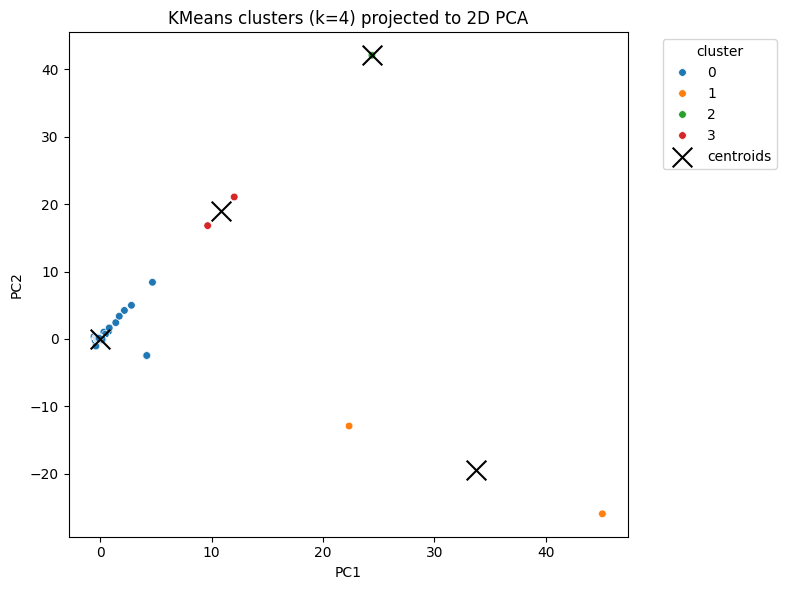

k=4 cluster sizes: 0:3521, 1:2, 2:1, 3:2
Centroids (original feature scale):
              0              1
0 -4.186719e+03    -269.843837
1  7.425317e+06    2110.460615
2 -3.391292e+04  498633.731892
3 -3.764101e+04  223632.747612




In [72]:
from sklearn.decomposition import PCA

# prepare k values: always show k=2 and the elbow/kneed-selected k if available
k_list = [4]
try:
    k_opt_val = int(k_opt)
    if k_opt_val not in k_list:
        k_list.append(k_opt_val)
except Exception:
    k_opt_val = None

# Fit KMeans and store models/labels
kmeans_models = {}
labels_dict = {}
for k in k_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(x_scaled)
    kmeans_models[k] = km
    labels_dict[k] = labels

# PCA to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(x_scaled)

import matplotlib.pyplot as plt
import seaborn as sns

for k in k_list:
    plt.figure(figsize=(8,6))
    # scatter plot colored by cluster label
    sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=labels_dict[k], palette='tab10', s=30, legend='full')
    # compute centroids in PCA space
    centers_pca = pca.transform(kmeans_models[k].cluster_centers_)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=200, marker='x', label='centroids')
    plt.title(f'KMeans clusters (k={k}) projected to 2D PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # print cluster sizes and centroids (inverse transform centroids to original feature scale)
    unique, counts = np.unique(labels_dict[k], return_counts=True)
    print(f'k={k} cluster sizes: ' + ', '.join([f'{int(u)}:{int(c)}' for u,c in zip(unique,counts)]))
    centers_orig = scaler.inverse_transform(kmeans_models[k].cluster_centers_)
    print('Centroids (original feature scale):')
    print(pd.DataFrame(centers_orig))
    print('\n')

In [73]:
x_scaled.dtype

dtype('float64')

In [74]:
df=pd.DataFrame(x_scaled)

In [75]:
df.head()

,0,1
0,-0.036588,-0.033186
1,-0.128287,-0.108468
2,0.048825,-0.097601
3,-0.167588,-0.063348
4,0.197115,0.017617


In [86]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)  # using k=4 based on your previous analysis
kmeans = kmeans.fit(x_scaled)

In [87]:
df['cluster'] = kmeans.labels_

In [88]:
cluster_0 = df[df['cluster'] == 0]
cluster_1 = df[df['cluster'] == 1]
cluster_2 = df[df['cluster'] == 2]
cluster_3 = df[df['cluster'] == 3]
cluster_4 = df[df['cluster'] == 4]
cluster_5 = df[df['cluster'] == 5]

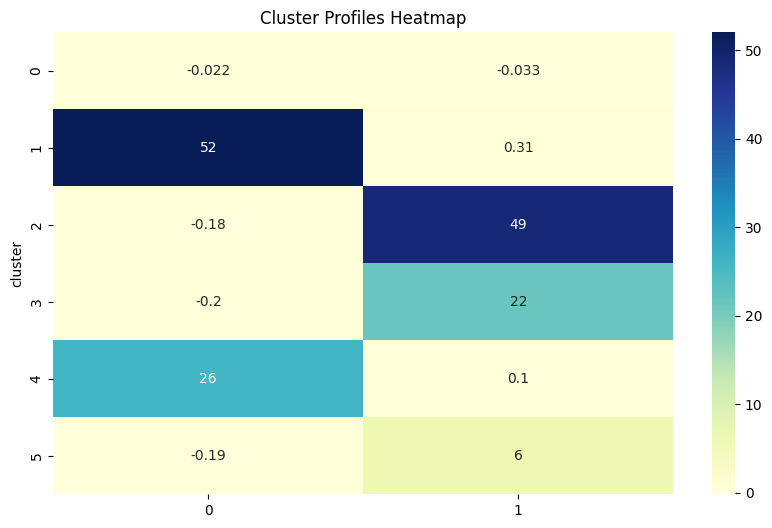

In [89]:
cluster_profile=df.groupby('cluster').mean()
plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap='YlGnBu')
plt.title('Cluster Profiles Heatmap')
plt.show()

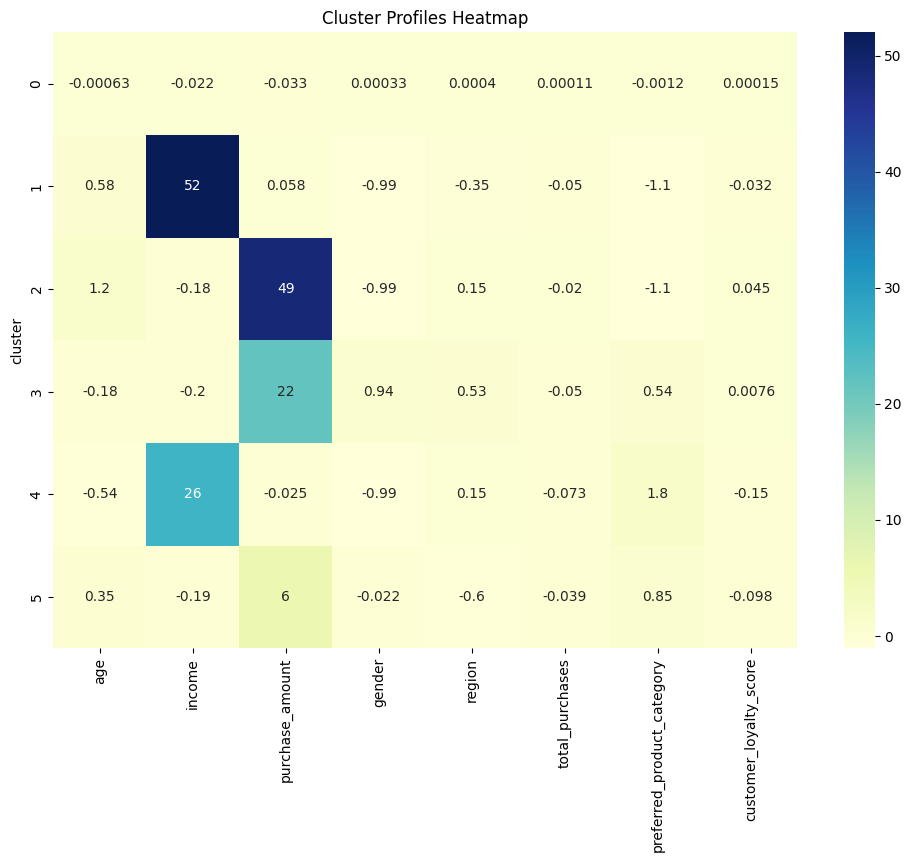

In [90]:
df_original = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Add cluster labels
df_original['cluster'] = kmeans.labels_

# Create cluster profile and plot heatmap
cluster_profile = df_original.groupby('cluster').mean()
plt.figure(figsize=(12,8))
sns.heatmap(cluster_profile, annot=True, cmap='YlGnBu')
plt.title('Cluster Profiles Heatmap')
plt.show()